In [78]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [79]:
# https://archive.ics.uci.edu/dataset/292/wholesale+customers
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
data = pd.read_csv(url)
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Dataset - Wholesale customers
Набор данных относится к клиентам оптового дистрибьютора.
Он включает ежегодные расходы в денежных единицах (m.u.) на различные категории продуктов.

Мы будем использовать данные о годовых расходах каждого клиента по шести товарным категориям (Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen) как основу для группировки. Алгоритм кластеризации будет анализировать эти шесть цифр для каждого клиента и объединять в один кластер (сегмент) тех клиентов, у которых структура расходов похожа.

In [80]:
data = data.drop(['Channel', 'Region'], axis = 1)


# Нам нужно привести все данные к одному маштабу
'''
В моем случае DBSCAN даже запускаться не хотел без логарифмирования
Скорее всего из за того что расстояние между точками слишком большее
И алгоритм все точки распознает как шум даже при eps = 400
'''

data = np.log1p(data)


In [81]:
# 1. KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

results = []

i_range = range(2, 100)
best_k = -1
best_k_score = -1
best_k_model = None
best_k_labels = None

for i in i_range:
    clf = KMeans(n_clusters=i)
    labels = clf.fit_predict(data)
    score = silhouette_score(data, labels)
    if score > best_k_score:
        best_k_score = score
        best_k = i
        best_k_model = clf
        best_k_labels = labels

results.append({
    'name': f'KMeans (k={best_k})',
    'score': best_k_score,
    'model': best_k_model,
    'labels': best_k_labels
})

print(f"Лучший результат для KMeans: Score={best_k_score} с k={best_k}")

Лучший результат для KMeans: Score=0.30130509254875354 с k=2


In [82]:
# 2. DBSCAN
from sklearn.cluster import DBSCAN

eps_range = np.linspace(0.01, 2.5, 100) 
best_eps = -1
best_dbs_score = -1
best_dbs_model = None
best_dbs_labels = None

for i in eps_range:
  clf = DBSCAN(eps=i)
  labels = clf.fit_predict(data)
  if len(set(labels)) > 1:
    score = silhouette_score(data, labels)
    if score > best_dbs_score:
      best_dbs_score = score
      best_eps = i
      best_dbs_model = clf
      best_dbs_labels = labels

results.append({
    'name': f'DBSCAN (eps={best_eps})',
    'score': best_dbs_score,
    'model': best_dbs_model,
    'labels': best_dbs_labels
})
print(f"Лучший результат для DBSCAN: Score={best_dbs_score} с eps={best_eps}")

Лучший результат для DBSCAN: Score=0.4348513341709299 с eps=2.474848484848485


In [83]:
# 3. AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

i_range = range(2, 100)
best_n_clusters = -1
best_ac_score = -1
best_ac_model = None
best_ac_labels = None

for i in i_range:
  clf = AgglomerativeClustering(n_clusters=i)
  labels = clf.fit_predict(data)
  score = silhouette_score(data, labels)
  if score > best_ac_score:
    best_ac_score = score
    best_n_clusters = i
    best_ac_model = clf
    best_ac_labels = labels

results.append({
    'name': f'AgglomerativeClustering(n_clusters={best_n_clusters})',
    'score': best_ac_score,
    'model': best_ac_model,
    'labels': best_ac_labels
})

print(f"Лучший результат для AgglomerativeClustering: Score={best_ac_score:.4f} с n_clusters={best_n_clusters}")

Лучший результат для AgglomerativeClustering: Score=0.2586 с n_clusters=2


In [84]:
# GMSDB
from gmsdb import GMSDB

n = 50
clf = GMSDB(n_components = n)
labels = clf.fit_predict(data)
score = silhouette_score(data, labels)

results.append({
  'name': f'GMSDB (n_components = {n})',
  'score' : score, 
  'model' : clf,
  'labels' : labels
})
print(f"Результат для GMSDB: score = {score}")

Результат для GMSDB: score = 0.25439288981454883


In [85]:
# OPTICS
from sklearn.cluster import OPTICS

n_range = range(2, 100)
best_n = -1
best_opt_score = -1
best_opt_clf = None
best_opt_label = None


for n in n_range:
  clf = OPTICS(min_samples = n)
  labels = clf.fit_predict(data)
  if len(np.unique(labels)) > 1:
    score = silhouette_score(data, labels)
    if score > best_opt_score:
      best_opt_score = score
      best_n = n
      best_opt_clf = clf
      best_opt_label = labels
    
results.append({
  'name' : f'OPTICS (min_samples = {best_n})',
  'score' : best_opt_score,
  'model' : best_opt_clf,
  'labels' : best_opt_label
})
print(f"Результат для OPTICS: score = {best_opt_score} при min_samples = {best_n}")

Результат для OPTICS: score = -0.14259556354327413 при min_samples = 12


In [86]:
best_result = max(results, key=lambda x: x['score'])

best_model_name = best_result['name']
best_score_value = best_result['score']
best_labels = best_result['labels']

print(f"Лучший алгоритм: {best_model_name}")
print(f"Score лучшей модели: {best_score_value:.4f}")

Лучший алгоритм: DBSCAN (eps=2.474848484848485)
Score лучшей модели: 0.4349


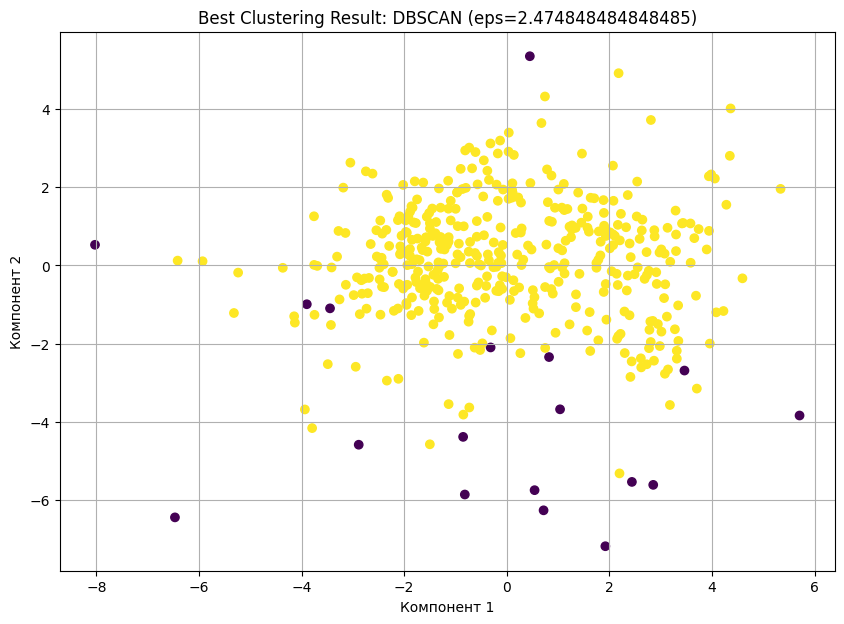

In [87]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_tr = pca.fit_transform(data)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(data_tr[:, 0], data_tr[:, 1], c=best_labels)
plt.title(f'Best Clustering Result: {best_model_name}')
plt.xlabel('Компонент 1')
plt.ylabel('Компонент 2')
plt.grid()
plt.show()

d:\Data_science\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


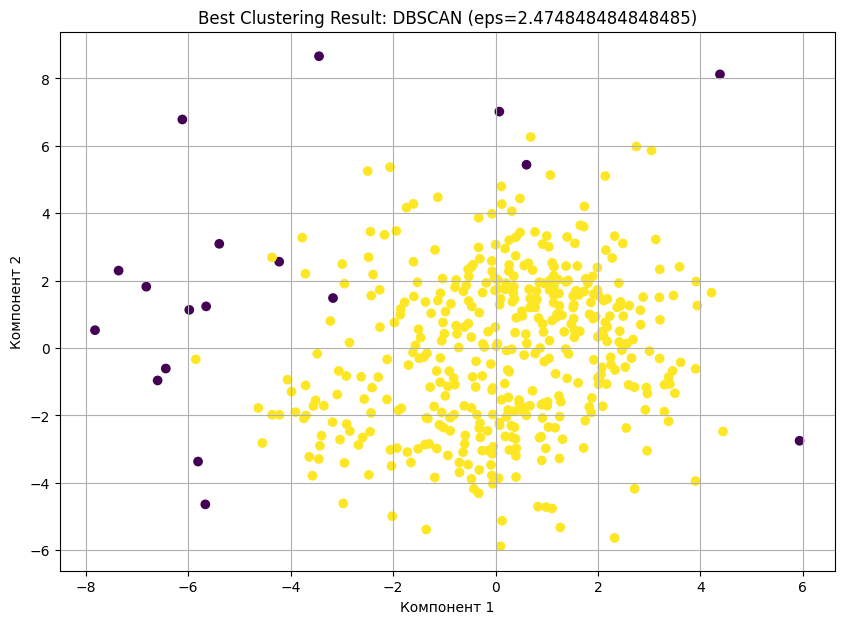

In [88]:
from sklearn.manifold import MDS
mds = MDS(n_components=2)
data_tr = mds.fit_transform(data)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(data_tr[:, 0], data_tr[:, 1], c=best_labels)
plt.title(f'Best Clustering Result: {best_model_name}')
plt.xlabel('Компонент 1')
plt.ylabel('Компонент 2')
plt.grid()
plt.show()

Буду благодарен получить объяснение почему DBSCAN разделяет точки на разные классы, которые находяться чуть ли не друг в друге. Честно не понимаю